In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from fsmodels import SklMultiExpFrequencyScan
from fsmodels import SklSingleExpFrequencyScan

from fsplots import plot_model
from fsplots import plot_loss_path
from fsplots import plot_experimental_points

%matplotlib inline

# Single exponential model class

In [3]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6)
fs

SklSingleExpFrequencyScan()

In [4]:
fs.get_params()

{'filling_pulse': 1.9999999999999998e-05,
 'fit_p_coef': True,
 'learning_rate': 0.1,
 'n_iters': 1000,
 'stop_val': None,
 'verbose': False}

In [5]:
X = np.linspace(0, 3.5, 100)
fs.exps_params_ = [[-2.5, 3.5]]
fs.p_coef_ = 0.3

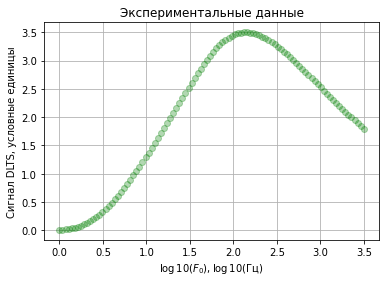

In [6]:
y = fs.predict(X)

plot_experimental_points(X, y)
plt.show()

In [7]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6,
                               fit_p_coef = True,
                               learning_rate = 0.1,
                               n_iters = 200, 
                               stop_val = 10**-5,
                               verbose = True)

fs.fit(X, y)

iteration # 0
loss: 5.0154849968520825
exps_params:
[[-2.62246365  0.25331878]]
p_coef: 1.0
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 1
loss: 4.597149771874943
exps_params:
[[-2.61277116  0.45818945]]
p_coef: 0.979350695041765
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 2
loss: 4.197973659067765
exps_params:
[[-2.59610179  0.65467738]]
p_coef: 0.9423846264985357
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 3
loss: 3.8055568434021416
exps_params:
[[-2.57422688  0.84437308]]
p_coef: 0.889156856150673
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 4
loss: 3.408218546347762
exps_params:
[[-2.54918268  1.02853271]]
p_coef: 0.8187804786318205
filling_p

p_coef: 0.2401287635019021
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 38
loss: 0.017220843287737167
exps_params:
[[-2.52768329  3.25843733]]
p_coef: 0.2677969972947708
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 39
loss: 0.014876753407629258
exps_params:
[[-2.51954404  3.27442907]]
p_coef: 0.24856346762310855
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 40
loss: 0.013188386440398507
exps_params:
[[-2.524187    3.28405251]]
p_coef: 0.26762851021976186
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 41
loss: 0.011596271771270919
exps_params:
[[-2.51851727  3.29748549]]
p_coef: 0.25585066680153784
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True

p_coef: 0.2929169774134446
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 74
loss: 0.00033131033394450705
exps_params:
[[-2.50314845  3.46475441]]
p_coef: 0.29327945798596555
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 75
loss: 0.0002981890813649248
exps_params:
[[-2.50298202  3.46655892]]
p_coef: 0.29362328214110306
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 76
loss: 0.00026839006610058185
exps_params:
[[-2.5028247   3.46827057]]
p_coef: 0.2939494423038975
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True


iteration # 77
loss: 0.0002415784282249244
exps_params:
[[-2.50267596  3.46989418]]
p_coef: 0.29425884146366815
filling_pulse: 1.9999999999999998e-05
fit_p_coef

SklSingleExpFrequencyScan(n_iters=200, stop_val=1e-05, verbose=True)

In [8]:
fs.print_all_params()

exps_params:
[[-2.50156501  3.48218404]]
p_coef: 0.2966015127978825
filling_pulse: 1.9999999999999998e-05
fit_p_coef: True
learning_rate: 0.1
n_iters: 200
stop_val: 1e-05
verbose: True




In [9]:
fs.fit_results_

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
0,0.253319,0.00002,True,0.1,5.015485,1,200,1.000000,0.00001,-2.622464,True
1,0.458189,0.00002,True,0.1,4.597150,1,200,0.979351,0.00001,-2.612771,True
2,0.654677,0.00002,True,0.1,4.197974,1,200,0.942385,0.00001,-2.596102,True
3,0.844373,0.00002,True,0.1,3.805557,1,200,0.889157,0.00001,-2.574227,True
4,1.028533,0.00002,True,0.1,3.408219,1,200,0.818780,0.00001,-2.549183,True
...,...,...,...,...,...,...,...,...,...,...,...
83,3.478027,0.00002,True,0.1,0.000129,1,200,0.295809,0.00001,-2.501938,True
84,3.479150,0.00002,True,0.1,0.000116,1,200,0.296023,0.00001,-2.501837,True
85,3.480215,0.00002,True,0.1,0.000104,1,200,0.296226,0.00001,-2.501741,True
86,3.481225,0.00002,True,0.1,0.000094,1,200,0.296419,0.00001,-2.501651,True


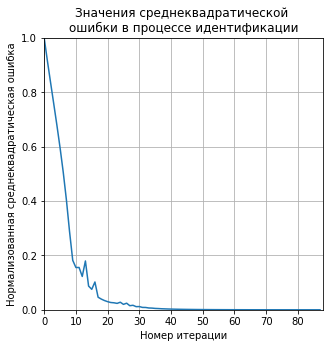

In [10]:
plot_loss_path(fs.fit_results_)
plt.show()

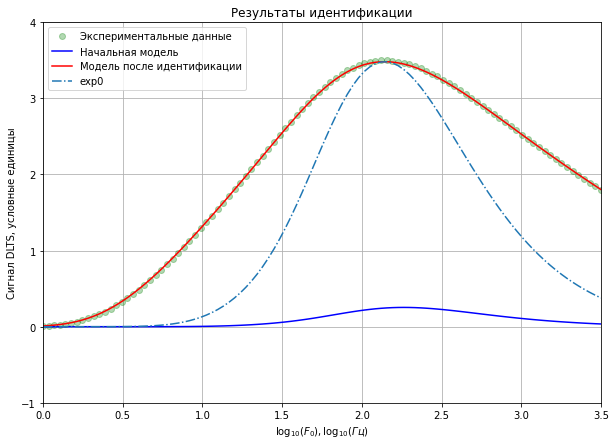

In [11]:
y_pred = fs.predict(X)

plot_model(X, y, SklSingleExpFrequencyScan, fs.fit_results_)
plt.show()

In [12]:
mean_squared_error(y, y_pred, squared=False)

0.009191131031780559

In [13]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

In [14]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6,
                               fit_p_coef = True,
                               learning_rate = 0.1,
                               n_iters = 200, 
                               stop_val = 10**-5,
                               verbose = False)

scores = cross_val_score(fs, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
display_scores(np.sqrt(-scores))

Scores: [0.00384926 0.0067345  0.03319435 0.05796781 0.00828144]
Mean: 0.022005473137780247
Standard deviation: 0.02083113390449091


In [15]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6,
                               fit_p_coef = True,
                               learning_rate = 0.1,
                               n_iters = 200, 
                               stop_val = 10**-5,
                               verbose = False)

grid_search = GridSearchCV(fs, {'fit_p_coef': [False, True]}, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [16]:
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=SklSingleExpFrequencyScan(n_iters=200, stop_val=1e-05),
             n_jobs=-1, param_grid={'fit_p_coef': [False, True]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [17]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

1.2827562021856516 {'fit_p_coef': False}
0.018056114702628495 {'fit_p_coef': True}


# Multi exponential model class

In [18]:
fs = SklMultiExpFrequencyScan(filling_pulse = 20*10**-6,
                              n_exps = 3,
                              learning_rate = 0.1,
                              n_iters = 1000, 
                              stop_val = 10**-5,
                              verbose = True)

# fs.exps_params_ = [[-1, 1], 
#                    [-2, 1], 
#                    [-3, 1]]

fs.exps_params_ = [[-1.0, 3.5],
                   [-2.3, 3.0],
                   [-3.5, 2.5]]

In [19]:
y = fs.predict(X)

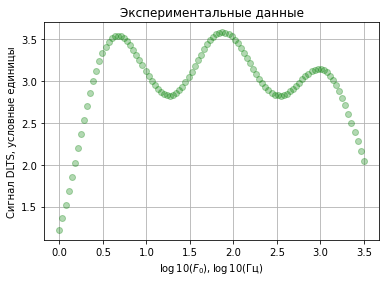

In [20]:
plot_experimental_points(X, y)
plt.show()

In [21]:
fs.fit(X, y)

iteration # 0
loss: 9.956027975490304
exps_params:
[[-1.20804055 -0.09929579]
 [-2.51392323 -0.05214857]
 [-2.10201158 -0.20048335]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 1
loss: 8.27551543695782
exps_params:
[[-1.20306771  0.14116948]
 [-2.51670435  0.18615316]
 [-2.10415946  0.05013792]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 2
loss: 6.928561020170289
exps_params:
[[-1.20815973  0.3598662 ]
 [-2.50939278  0.39850877]
 [-2.10369006  0.27167969]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 3
loss: 5.848032622109101
exps_params:
[[-1.21596715  0.55926627]
 [-2.49911541  0.58802854]
 [-2.10160165  0.46716881]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 4
los

iteration # 34
loss: 0.17589862379054338
exps_params:
[[-1.00242365  2.89333159]
 [-3.26050525  2.49990335]
 [-2.14791846  2.36285617]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 35
loss: 0.15988812429221028
exps_params:
[[-1.00201496  2.92052779]
 [-3.27101573  2.5146156 ]
 [-2.15371833  2.38574442]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 36
loss: 0.14548460710164005
exps_params:
[[-1.0016349   2.94645765]
 [-3.28092304  2.52808709]
 [-2.15921005  2.40762502]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 37
loss: 0.13251508942059492
exps_params:
[[-1.00128164  2.97117997]
 [-3.29027435  2.54040889]
 [-2.16441663  2.42854855]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iter

iteration # 67
loss: 0.012746075726872662
exps_params:
[[-0.998436    3.35904655]
 [-3.43387995  2.63785803]
 [-2.2496151   2.7803065 ]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 68
loss: 0.011954241432208725
exps_params:
[[-0.99846129  3.36490773]
 [-3.43617146  2.63697382]
 [-2.25112045  2.78649545]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 69
loss: 0.011220052040046976
exps_params:
[[-0.99848829  3.37051246]
 [-3.43837327  2.63599628]
 [-2.25257485  2.7924758 ]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 70
loss: 0.010538707452821679
exps_params:
[[-0.99851672  3.3758725 ]
 [-3.44048922  2.63493371]
 [-2.25398024  2.79825609]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True




iteration # 100
loss: 0.00207224491184243
exps_params:
[[-0.99939491  3.46346879]
 [-3.4774938   2.58843214]
 [-2.2803395   2.90820698]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 101
loss: 0.00197416543452956
exps_params:
[[-0.99941656  3.46487503]
 [-3.47815848  2.58687092]
 [-2.28085968  2.91044356]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 102
loss: 0.0018811510048806538
exps_params:
[[-0.9994376   3.46622378]
 [-3.47880042  2.58532495]
 [-2.28136451  2.91261871]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 103
loss: 0.0017929037327307452
exps_params:
[[-0.99945805  3.46751751]
 [-3.4794205   2.58379486]
 [-2.28185449  2.91473442]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: Tru

iteration # 133
loss: 0.00045164970394264315
exps_params:
[[-0.999848    3.4894536 ]
 [-3.49103225  2.54653776]
 [-2.29156847  2.95795063]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 134
loss: 0.0004318936217365914
exps_params:
[[-0.99985533  3.48982596]
 [-3.49126217  2.54558662]
 [-2.29177371  2.95889999]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 135
loss: 0.00041301913117523613
exps_params:
[[-0.9998624   3.49018421]
 [-3.4914854   2.54465286]
 [-2.29197358  2.9598265 ]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True


iteration # 136
loss: 0.00039498528381605864
exps_params:
[[-0.99986921  3.49052892]
 [-3.49170218  2.54373628]
 [-2.29216823  2.96073078]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbo

SklMultiExpFrequencyScan(n_exps=3, stop_val=1e-05, verbose=True)

In [22]:
fs.print_all_params()

exps_params:
[[-0.99994185  3.49420008]
 [-3.49416694  2.53258453]
 [-2.29442176  2.97135927]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 3
n_iters: 1000
stop_val: 1e-05
verbose: True




In [23]:
fs.fit_results_

,amplitude_0,amplitude_1,amplitude_2,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,verbose
0,-0.099296,-0.052149,-0.200483,0.00002,0.1,9.956028,3,1000,0.00001,-1.208041,-2.513923,-2.102012,True
1,0.141169,0.186153,0.050138,0.00002,0.1,8.275515,3,1000,0.00001,-1.203068,-2.516704,-2.104159,True
2,0.359866,0.398509,0.271680,0.00002,0.1,6.928561,3,1000,0.00001,-1.208160,-2.509393,-2.103690,True
3,0.559266,0.588029,0.467169,0.00002,0.1,5.848033,3,1000,0.00001,-1.215967,-2.499115,-2.101602,True
4,0.741040,0.757031,0.639128,0.00002,0.1,4.984127,3,1000,0.00001,-1.220430,-2.491306,-2.098965,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,3.493340,2.535467,2.968673,0.00002,0.1,0.000253,3,1000,0.00001,-0.999925,-3.493559,-2.293859,True
147,3.493567,2.534725,2.969369,0.00002,0.1,0.000242,3,1000,0.00001,-0.999929,-3.493717,-2.294005,True
148,3.493786,2.533997,2.970048,0.00002,0.1,0.000232,3,1000,0.00001,-0.999934,-3.493871,-2.294147,True
149,3.493997,2.533284,2.970711,0.00002,0.1,0.000222,3,1000,0.00001,-0.999938,-3.494021,-2.294286,True


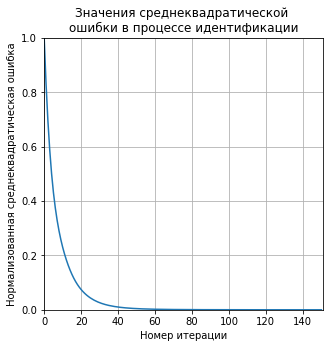

In [24]:
plot_loss_path(fs.fit_results_)
plt.show()

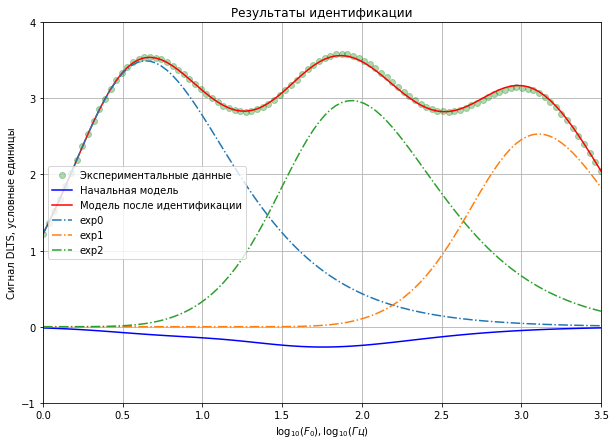

In [25]:
plot_model(X, y, SklMultiExpFrequencyScan, fs.fit_results_)
plt.show()

In [26]:
mean_squared_error(y, fs.predict(X), squared=False)

0.014563384924066555

In [27]:
fs = SklSingleExpFrequencyScan(filling_pulse = 20*10**-6,
                               fit_p_coef = True,
                               learning_rate = 0.1,
                               n_iters = 1000, 
                               stop_val = 10**-5,
                               verbose = False)

scores = cross_val_score(fs, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
display_scores(np.sqrt(-scores))

Scores: [2.58482136        nan        nan 2.98245743 2.83911354]
Mean: nan
Standard deviation: nan


In [28]:
fs = SklMultiExpFrequencyScan(filling_pulse = 20*10**-6,
                              n_exps = 3,
                              learning_rate = 0.1,
                              n_iters = 1000, 
                              stop_val = 10**-5,
                              verbose = False)

grid_search = GridSearchCV(fs, {'n_exps': [2, 3, 4, 5, 6]}, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [29]:
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=SklMultiExpFrequencyScan(n_exps=3, stop_val=1e-05),
             n_jobs=-1, param_grid={'n_exps': [2, 3, 4, 5, 6]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [30]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

1.9518068382788625 {'n_exps': 2}
0.3662826800544275 {'n_exps': 3}
0.3614633867671616 {'n_exps': 4}
0.35410708297337107 {'n_exps': 5}
0.35085993074686633 {'n_exps': 6}


In [31]:
grid_search.best_estimator_.print_all_params()

exps_params:
[[-3.29683609  1.23894607]
 [-0.96310641  1.75988844]
 [-1.03073013  1.7289944 ]
 [-2.28884417  1.46428707]
 [-2.26907831  1.44425214]
 [-3.65753491  1.44006796]]
filling_pulse: 1.9999999999999998e-05
learning_rate: 0.1
n_exps: 6
n_iters: 1000
stop_val: 1e-05
verbose: False




In [32]:
grid_search.best_estimator_.fit_results_

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,verbose
0,0.021314,0.016228,0.084647,0.021321,-0.044460,-0.122529,0.00002,0.1,9.103420,6,1000,0.00001,-2.689982,-1.123240,-1.576342,-2.497767,-2.327769,-3.266777,False
1,0.240977,0.237817,0.316885,0.249118,0.187813,0.055672,0.00002,0.1,6.475629,6,1000,0.00001,-2.688858,-1.124163,-1.576787,-2.496999,-2.328648,-3.280038,False
2,0.416220,0.430256,0.510310,0.430233,0.372791,0.203380,0.00002,0.1,4.705476,6,1000,0.00001,-2.680170,-1.132000,-1.572620,-2.489932,-2.324917,-3.275759,False
3,0.555854,0.598129,0.671420,0.573717,0.519400,0.327998,0.00002,0.1,3.502677,6,1000,0.00001,-2.671060,-1.137068,-1.558598,-2.480867,-2.318010,-3.265662,False
4,0.666802,0.744657,0.805853,0.686863,0.634983,0.434286,0.00002,0.1,2.675705,6,1000,0.00001,-2.665327,-1.134007,-1.532914,-2.472453,-2.309437,-3.256793,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,1.240883,1.759771,1.728875,1.463249,1.443221,1.441834,0.00002,0.1,0.001054,6,1000,0.00001,-3.294725,-0.962689,-1.031017,-2.288665,-2.268324,-3.658881,False
177,1.240394,1.759801,1.728905,1.463512,1.443482,1.441389,0.00002,0.1,0.001043,6,1000,0.00001,-3.295256,-0.962794,-1.030945,-2.288710,-2.268515,-3.658543,False
178,1.239908,1.759830,1.728935,1.463772,1.443741,1.440946,0.00002,0.1,0.001033,6,1000,0.00001,-3.295785,-0.962899,-1.030873,-2.288755,-2.268705,-3.658207,False
179,1.239426,1.759859,1.728965,1.464031,1.443997,1.440506,0.00002,0.1,0.001023,6,1000,0.00001,-3.296312,-0.963003,-1.030801,-2.288799,-2.268892,-3.657870,False


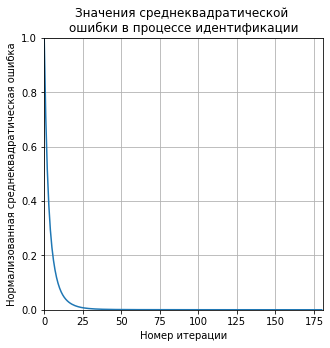

In [33]:
plot_loss_path(grid_search.best_estimator_.fit_results_)
plt.show()

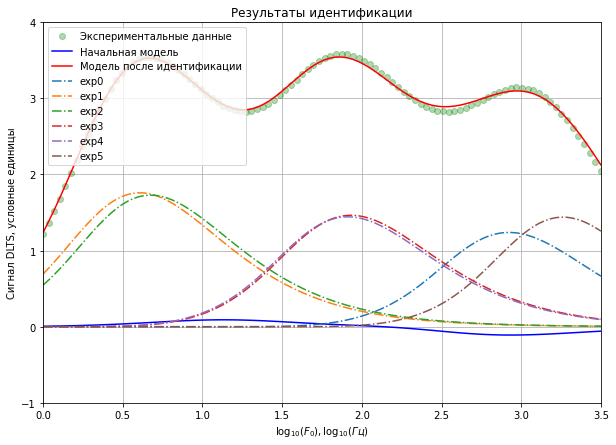

In [34]:
plot_model(X, y, SklMultiExpFrequencyScan, grid_search.best_estimator_.fit_results_)
plt.show()

In [35]:
mean_squared_error(y, grid_search.best_estimator_.predict(X), squared=False)

0.03182703644907056